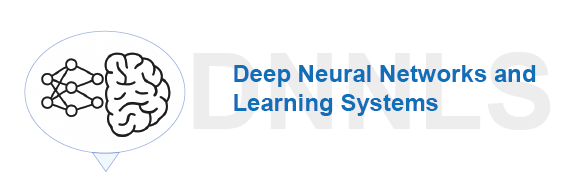

# Final assessment - Main Notebook
---

**Introduction:**

In this notebook you will find a baseline, functional architecture for your assessment task.

In [ ]:
# @title Importing the necessary libraries
import torch 
import torch.nn as nn
import torch.nn.functional as F

from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
import os

from datasets import load_dataset

from datasets.fingerprint import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.transforms.functional as FT
from transformers import BertTokenizer
import gc
import textwrap



# **Chapter 1: The data preparation**


---



First we need to activate our google drive so that we can save out data permanently.

## 1.1 Loading and saving data

In [ ]:
# @title Setting up google drive to save checkpoints

# This will prompt you to authorize Google Drive access
drive.mount('/content/gdrive')

def save_checkpoint_to_drive(model, optimizer, epoch, loss, filename="autoencoder_checkpoint.pth"):
    """
    Saves the checkpoint directly to a specified folder in your mounted Google Drive.
    """
    # 1. Define the full Google Drive path
    # 'DL_Checkpoints' is the folder you want to save to inside your Drive
    drive_folder = '/content/gdrive/MyDrive/DL_Checkpoints'

    # Ensure the directory exists before attempting to save
    os.makedirs(drive_folder, exist_ok=True)

    # 2. Combine the folder and the filename
    full_path = os.path.join(drive_folder, filename)

    # 3. Create the checkpoint dictionary
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    # 4. Save the dictionary to the Google Drive path
    torch.save(checkpoint, full_path)
    print(f"Checkpoint saved to Google Drive: {full_path} at epoch {epoch}")


def load_checkpoint_from_drive(model, optimizer=None, filename="autoencoder_checkpoint.pth"):
    """
    Loads a checkpoint from your Google Drive folder into the model and optimizer (if provided).
    """
    # Define the same Google Drive folder path
    drive_folder = '/content/gdrive/MyDrive/DL_Checkpoints'
    full_path = os.path.join(drive_folder, filename)

    # Check if the checkpoint file exists
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Checkpoint file not found: {full_path}")

    # Load the checkpoint
    checkpoint = torch.load(full_path, map_location=torch.device('cpu'))  # use cuda if available

    # Restore model state
    model.load_state_dict(checkpoint['model_state_dict'])

    # Restore optimizer state (if provided)
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Extract metadata
    epoch = checkpoint.get('epoch', 0)
    loss = checkpoint.get('loss', None)

    print(f"Checkpoint loaded from: {full_path} (epoch {epoch})")

    return model, optimizer, epoch, loss


Mounted at /content/gdrive


We need to define a couple of functions to make our life easier. Feel free to tweak those functions:

In [ ]:
# @title Functions to load images and process data


# This function just extracts the tags from the text, don't get distracted by it.
# I changed this function a bit to fix some bugs
def parse_gdi_text(text):
    """Parse GDI formatted text into structured data"""
    soup = BeautifulSoup(text, 'html.parser')
    images = []

    for gdi in soup.find_all('gdi'):
        # Debug: print what BeautifulSoup sees

        # Method 1: Try to get image attribute directly
        image_id = None
        if gdi.attrs:
            # Check for attributes like 'image1', 'image2', etc.
            for attr_name, attr_value in gdi.attrs.items():
                if 'image' in attr_name.lower():
                    image_id = attr_name.replace('image', '')
                    break

        # Method 2: Extract from the tag string using regex
        if not image_id:
            tag_str = str(gdi)
            match = re.search(r'<gdi\s+image(\d+)', tag_str)
            if match:
                image_id = match.group(1)

        # Method 3: Fallback - use sequential numbering
        if not image_id:
            image_id = str(len(images) + 1)

        content = gdi.get_text().strip()

        # Extract tagged elements using BeautifulSoup directly
        objects = [obj.get_text().strip() for obj in gdi.find_all('gdo')]
        actions = [act.get_text().strip() for act in gdi.find_all('gda')]
        locations = [loc.get_text().strip() for loc in gdi.find_all('gdl')]

        images.append({
            'image_id': image_id,
            'description': content,
            'objects': objects,
            'actions': actions,
            'locations': locations,
            'raw_text': str(gdi)
        })

    return images

# This is an utility function to show images.
# Why do we need to do all this?
def show_image(ax, image, de_normalize = False, img_mean = None, img_std = None):
  """
  De-normalize the image (if necessary) and show image
  """
  if de_normalize:
    new_mean = -img_mean/img_std
    new_std = 1/img_std

    image = transforms.Normalize(
        mean=new_mean,
        std=new_std
    )(image)
  ax.imshow(image.permute(1, 2, 0))



Now we load dataset from HuggingFace:

In [ ]:
# @title Loading the dataset
train_dataset = load_dataset("daniel3303/StoryReasoning", split="train")
test_dataset = load_dataset("daniel3303/StoryReasoning", split="test")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/327M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/331M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3552 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/626 [00:00<?, ? examples/s]

In a previous lab, we analyzed the statistics of the images and figure out that a size of 240x500 could be good enough to standarize, but we will use 60x125. Also, we will restrict ourselves to taking only 5 frames from all the sequences.


## 1.2 Three datasets


---



We will create three different dataset objects and the corresponding loaders for performing multiple tasks

# Bseline model **dataset**

# 1.2.1 Baseline Model Dataset (No Tags)

This dataset provides image frames and textual descriptions only.
It is used to train and evaluate the baseline storytelling model without tag information.

In [ ]:
# @title 1.2.1 Main dataset without tags
class SequencePredictionDatasetBaseline(Dataset):
    def __init__(self, original_dataset, tokenizer):
        super(SequencePredictionDatasetBaseline, self).__init__()
        self.dataset = original_dataset
        self.tokenizer = tokenizer
        # Potential experiments: Try other transforms!
        self.transform = transforms.Compose([
          transforms.Resize((60, 125)),# Reasonable size based on our previous analysis
          transforms.ToTensor(), # HxWxC -> CxHxW
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      """
      Selects a 5 frame sequence from the dataset. Sets 4 for training and the last one
      as a target.
      """
      num_frames = self.dataset[idx]["frame_count"]
      frames = self.dataset[idx]["images"]
      self.image_attributes = parse_gdi_text(self.dataset[idx]["story"])

      frame_tensors = []
      description_list = []

      for frame_idx in range(4):
        image = FT.equalize(frames[frame_idx])
        input_frame = self.transform(image)
        frame_tensors.append(input_frame)

        # Potential experiments: Try using the other attributes in your training
        # objects = self.image_attributes[frame_idx]["objects"]
        # actions = self.image_attributes[frame_idx]["actions"]
        # locations = self.image_attributes[frame_idx]["locations"]

        description = self.image_attributes[frame_idx]["description"]
        # We need to return the tokens for NLP
        input_ids =  self.tokenizer(description,
                             return_tensors="pt",
                             padding="max_length",
                             truncation=True,
                             max_length=120).input_ids

        description_list.append(input_ids.squeeze(0))


      image_target = FT.equalize(frames[4])
      image_target = self.transform(image_target)
      text_target = self.image_attributes[4]["description"]

      target_ids = tokenizer(text_target,
                             return_tensors="pt",
                             padding="max_length",
                             truncation=True,
                             max_length=120).input_ids.squeeze(0)

      sequence_tensor = torch.stack(frame_tensors)  # shape: (num_frames, C, H, W)
      description_tensor = torch.stack(description_list) # (num_frames, max_length)

      return (sequence_tensor, # Returning the image
              description_tensor, # Returning the whole description
              image_target, # Image target
              target_ids) # Text target



# 1.2.2 Tag Vocabulary Construction (Improved Model Only)

This step builds a vocabulary of semantic tags (objects, actions, locations) using only the training split to avoid data leakage.

In [ ]:
from collections import Counter

# ============================================================
# @title 1.2.2 TAG VOCABULARY (IMPROVED MODEL ONLY)
# ============================================================
# This function scans ONLY the TRAINING dataset and builds a
# vocabulary of tags (objects, actions, locations).
# This avoids data leakage.
# ============================================================

def build_tag_vocab(dataset, max_samples=None, min_freq=1):
    """
    Build a tag vocabulary from the training dataset.

    Args:
        dataset: HuggingFace dataset split (train only)
        max_samples: Optional limit on number of samples to scan
        min_freq: Minimum frequency for a tag to be kept

    Returns:
        tag_to_idx: Dictionary mapping tag -> index
        idx_to_tag: Dictionary mapping index -> tag
    """
    tag_counter = Counter()

    for i, sample in enumerate(dataset):
        if max_samples is not None and i >= max_samples:
            break

        # Parse story into per-frame attributes
        attrs = parse_gdi_text(sample["story"])  # list of 5 frame dicts

        for frame in attrs:
            # Collect all semantic tags
            tags = frame["objects"] + frame["actions"] + frame["locations"]
            for t in tags:
                t = t.strip().lower()
                if t:
                    tag_counter[t] += 1

    # Keep only tags with frequency >= min_freq
    tags = [t for t, c in tag_counter.items() if c >= min_freq]

    # Create mappings
    tag_to_idx = {t: idx for idx, t in enumerate(sorted(tags))}
    idx_to_tag = {idx: t for t, idx in tag_to_idx.items()}

    print(f"Built tag vocabulary with {len(tag_to_idx)} tags")
    return tag_to_idx, idx_to_tag


# ------------------------------------------------------------
# Build tag vocabulary from TRAINING data only
# ------------------------------------------------------------
tag_to_idx, idx_to_tag = build_tag_vocab(train_dataset, max_samples=None, min_freq=1)
num_tags = len(tag_to_idx)
print("num_tags =", num_tags)


Built tag vocabulary with 29930 tags
num_tags = 29930


# 1.2.3 Tag-Augmented Dataset (With Tags)

This dataset extends the baseline dataset by including semantic tag vectors as additional inputs and targets, enabling multi-task learning.

In [ ]:
# ============================================================
#@title 1.2.3 MAIN DATASET (IMPROVED MODEL – WITH TAGS)
# ============================================================
# Returns:
#  - 4 input frames (images)
#  - 4 input texts
#  - 4 input tag vectors
#  - 1 target image (5th frame)
#  - 1 target text (5th frame)
#  - 1 target tag vector (5th frame)
# ============================================================

# @title Main dataset (WITH TAGS)
class SequencePredictionDatasetTags(Dataset):
    def __init__(self, original_dataset, tokenizer, tag_to_idx):
        super().__init__()
        self.dataset = original_dataset
        self.tokenizer = tokenizer
        self.tag_to_idx = tag_to_idx
        self.num_tags = len(tag_to_idx)

        # Image preprocessing
        self.transform = transforms.Compose([
            transforms.Resize((60, 125)),  # Standardized image size
            transforms.ToTensor(),         # HxWxC -> CxHxW
        ])

    def __len__(self):
        return len(self.dataset)

    def encode_tags(self, frame_attrs):
        """
        Convert objects/actions/locations of a frame
        into a multi-hot tag vector.

        Returns:
            Tensor of shape [num_tags]
        """
        vec = torch.zeros(self.num_tags, dtype=torch.float32)
        tags = frame_attrs["objects"] + frame_attrs["actions"] + frame_attrs["locations"]

        for t in tags:
            t = t.strip().lower()
            if t in self.tag_to_idx:
                vec[self.tag_to_idx[t]] = 1.0

        return vec

    def __getitem__(self, idx):
        """
        Select a 5-frame sequence:
        - Frames 0–3 → inputs
        - Frame 4     → targets
        """
        frames = self.dataset[idx]["images"]
        self.image_attributes = parse_gdi_text(self.dataset[idx]["story"])  # list of 5 dicts

        frame_tensors = []
        description_list = []
        tag_vectors = []

        # ----------------------------------------------------
        # Frames 0–3: INPUTS
        # ----------------------------------------------------
        for frame_idx in range(4):
            # Image
            image = FT.equalize(frames[frame_idx])
            input_frame = self.transform(image)
            frame_tensors.append(input_frame)

            # Text description
            description = self.image_attributes[frame_idx]["description"]
            input_ids = self.tokenizer(
                description,
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=120
            ).input_ids
            description_list.append(input_ids.squeeze(0))  # [120]

            # Tag vector
            tag_vec = self.encode_tags(self.image_attributes[frame_idx])
            tag_vectors.append(tag_vec)

        # ----------------------------------------------------
        # Frame 4: TARGETS
        # ----------------------------------------------------
        image_target = FT.equalize(frames[4])
        image_target = self.transform(image_target)  # [3, 60, 125]

        text_target = self.image_attributes[4]["description"]
        target_ids = self.tokenizer(
            text_target,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=120
        ).input_ids.squeeze(0)  # [120]

        tag_target = self.encode_tags(self.image_attributes[4])  # [num_tags]

        # ----------------------------------------------------
        # Stack tensors
        # ----------------------------------------------------
        sequence_tensor = torch.stack(frame_tensors)        # [4, 3, 60, 125]
        description_tensor = torch.stack(description_list)  # [4, 120]
        tag_seq = torch.stack(tag_vectors)                  # [4, num_tags]

        # ----------------------------------------------------
        # Return sample
        # ----------------------------------------------------
        return (
            sequence_tensor,        # Input image sequence
            description_tensor,     # Input text sequence
            image_target,           # Target image (5th frame)
            target_ids,             # Target text (5th frame)
            tag_seq,                # Input tag sequence
            tag_target              # Target tags (5th frame)
        )


We will use text autoencoding (reconstructing the same text) to develop representations of the text (I provide some existing weights for this, but you can train your own)

In [ ]:
# @title Text task dataset (text autoencoding)
class TextTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      num_frames = self.dataset[idx]["frame_count"]
      self.image_attributes = parse_gdi_text(self.dataset[idx]["story"])

      # Pick
      frame_idx = np.random.randint(0, 5)
      description = self.image_attributes[frame_idx]["description"]

      return description  # Returning the whole description


And also a dataset for a potential image autoencoder task if you want to develop some visual features before training the whose archicture.

In [ ]:
# @title Dataset for image autoencoder task
class AutoEncoderTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
          transforms.Resize((240, 500)),# Reasonable size based on our previous analysis
          transforms.ToTensor(), # HxWxC -> CxHxW
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      num_frames = self.dataset[idx]["frame_count"]
      frames = self.dataset[idx]["images"]

      # Pick a frame at random
      frame_idx = torch.randint(0, num_frames-1, (1,)).item()
      input_frame = self.transform(frames[frame_idx]) # Input to the autoencoder

      return input_frame, # Returning the image

## 1.3 Creating and testing our dataset objects and loaders


---



# 1.3.1 DataLoaders for Baseline Model


In [ ]:
# @title For the Sequence prediction task (BASELINE without Tags)

tokenizer = BertTokenizer.from_pretrained(
    "google-bert/bert-base-uncased",
    padding=True,
    truncation=True
)

sp_train_dataset = SequencePredictionDatasetBaseline(train_dataset, tokenizer)
sp_test_dataset  = SequencePredictionDatasetBaseline(test_dataset, tokenizer)

train_size = int(0.8 * len(sp_train_dataset))
val_size   = len(sp_train_dataset) - train_size
train_subset, val_subset = random_split(sp_train_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True)
val_dataloader   = DataLoader(val_subset, batch_size=4, shuffle=True)
test_dataloader  = DataLoader(sp_test_dataset, batch_size=4, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# 1.3.2 DataLoaders for Tag-Augmented Model




In [ ]:
# @title For the Sequence prediction task (WITH TAGS for improved Model)

sp_train_dataset_tags = SequencePredictionDatasetTags(train_dataset, tokenizer, tag_to_idx)
sp_test_dataset_tags  = SequencePredictionDatasetTags(test_dataset, tokenizer, tag_to_idx)

train_size = int(0.8 * len(sp_train_dataset_tags))
val_size   = len(sp_train_dataset_tags) - train_size
train_subset_tags, val_subset_tags = random_split(
    sp_train_dataset_tags, [train_size, val_size]
)

train_dataloader_tags = DataLoader(train_subset_tags, batch_size=8, shuffle=True)
val_dataloader_tags   = DataLoader(val_subset_tags, batch_size=4, shuffle=True)
test_dataloader_tags  = DataLoader(sp_test_dataset_tags, batch_size=4, shuffle=False)


In [ ]:
# @title For the text task
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased",  padding=True, truncation=True)
text_dataset = TextTaskDataset(train_dataset)
text_dataloader = DataLoader(text_dataset, batch_size=4, shuffle=True)

In [ ]:
# @title For the image autoencoder task
autoencoder_dataset = AutoEncoderTaskDataset(train_dataset)
autoencoder_dataloader = DataLoader(autoencoder_dataset, batch_size=4, shuffle=True)

# 1.3.3  Checks and Dataset Visualization


Description:  torch.Size([4, 120])
torch.Size([8, 4, 3, 60, 125])
torch.Size([8, 4, 120])


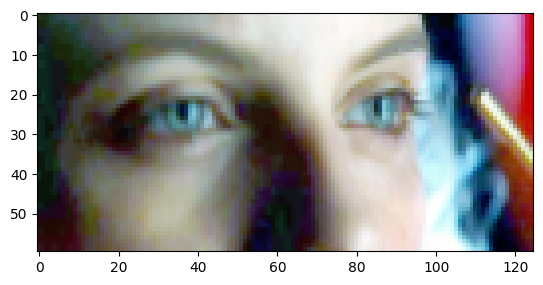

In [ ]:
# @title Testing some of the outputs of the SP dataset without tags
frames, descriptions, image_target, text_target = sp_train_dataset[np.random.randint(0,400)]

print("Description: ", descriptions.shape)
figure, ax = plt.subplots(1,1)
show_image(ax, image_target)

# Do some tests on the batches (try with batch size small)
frames, descriptions, image_target, text_target = next(iter(train_dataloader))
print(frames.shape)
print(descriptions.shape)

**Testing some of the outputs of the SP dataset >> improved model**

Description: torch.Size([4, 120])


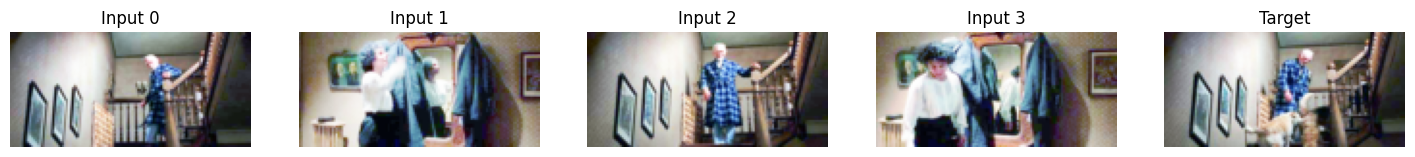

frames: torch.Size([8, 4, 3, 60, 125])
descriptions: torch.Size([8, 4, 120])
image_target: torch.Size([8, 3, 60, 125])
text_target: torch.Size([8, 120])
tag_seq: torch.Size([8, 4, 29930])
tag_target: torch.Size([8, 29930])


In [ ]:
# @title Testing some of the outputs of the SP dataset (WITH TAGS)

frames, descriptions, image_target, text_target, tag_seq, tag_target = \
    sp_train_dataset_tags[np.random.randint(0, 400)]

print("Description:", descriptions.shape)

fig, axes = plt.subplots(1, 5, figsize=(18, 4))
for i in range(4):
    show_image(axes[i], frames[i])
    axes[i].set_title(f"Input {i}")
    axes[i].axis("off")

show_image(axes[4], image_target)
axes[4].set_title("Target")
axes[4].axis("off")
plt.show()

frames, descriptions, image_target, text_target, tag_seq, tag_target = \
    next(iter(train_dataloader_tags))

print("frames:", frames.shape)
print("descriptions:", descriptions.shape)
print("image_target:", image_target.shape)
print("text_target:", text_target.shape)
print("tag_seq:", tag_seq.shape)
print("tag_target:", tag_target.shape)


I will leave the test of the other datasets to you.

# **Chapter 2: Models**


---



We provide a simple text encoder based on a recurrent neural network (LSTM). Feel free to provide your own text encoder.

## 2.1 The NLP models

In [ ]:
# @title The text autoencoder (Seq2Seq)

class EncoderLSTM(nn.Module):
    """
      Encodes a sequence of tokens into a latent space representation.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class DecoderLSTM(nn.Module):
    """
      Decodes a latent space representation into a sequence of tokens.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.out = nn.Linear(hidden_dim, vocab_size) # Should be hidden_dim

    def forward(self, input_seq, hidden, cell):
        embedded = self.embedding(input_seq)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.out(output)
        return prediction, hidden, cell

# We create the basic text autoencoder (a special case of a sequence to sequence model)
class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, target_seq):
        # input_seq and target_seq are both your 'input_ids'
        # 1. Encode the input sequence
        _enc_out, hidden, cell = self.encoder(input_seq)

        # 2. Create the "shifted" decoder input for teacher forcing.
        # We want to predict target_seq[:, 1:]
        # So, we feed in target_seq[:, :-1]
        # (i.e., feed "[SOS], hello, world" to predict "hello, world, [EOS]")
        decoder_input = target_seq[:, :-1]

        # 3. Run the decoder *once* on the entire sequence.
        # It takes the encoder's final state (hidden, cell)
        # and the full "teacher" sequence (decoder_input).
        predictions, _hidden, _cell = self.decoder(decoder_input, hidden, cell)

        # predictions shape will be (batch_size, seq_len-1, vocab_size)
        return predictions


In [ ]:
# @title Utility functions for NLP tasks
def generate(model, hidden, cell, max_len, sos_token_id, eos_token_id):
      """
        This function generates a sequence of tokens using the provided decoder.
      """
      # Ensure the model is in evaluation mode
      model.eval()

      # 2. SETUP DECODER INPUT
      # Start with the SOS token, shape (1, 1)
      dec_input = torch.tensor([[sos_token_id]], dtype=torch.long, device=device)
      # hidden = torch.zeros(1, 1, hidden_dim, device=device)
      # cell = torch.zeros(1, 1, hidden_dim, device=device)

      generated_tokens = []

      # 3. AUTOREGRESSIVE LOOP
      for _ in range(max_len):
          with torch.no_grad():
              # Run the decoder one step at a time
              # dec_input is (1, 1) here—it's just the last predicted token
              prediction, hidden, cell = model(dec_input, hidden, cell)

          logits = prediction.squeeze(1) # Shape (1, vocab_size)
          temperature = 0.9 # <--- Try a value between 0.5 and 1.0

          # 1. Divide logits by temperature
          # 2. Apply softmax to get probabilities
          # 3. Use multinomial to sample one token based on the probabilities
          probabilities = torch.softmax(logits / temperature, dim=-1)
          next_token = torch.multinomial(probabilities, num_samples=1)

          token_id = next_token.squeeze().item()

          # Check for the End-of-Sequence token
          if token_id == eos_token_id:
              break

          if token_id == 0 or token_id == sos_token_id:
              continue

            # Append the predicted token
          generated_tokens.append(token_id)

          # The predicted token becomes the input for the next iteration
          dec_input = next_token

      # Return the list of generated token IDs
      return generated_tokens


In [ ]:
# @title Do some tests
# desc = text_dataset[np.random.randint(0, 100)]
# print(f"Input: {desc}")
# input_ids = tokenizer(desc, return_tensors="pt",  padding=True, truncation=True).input_ids
# input_ids = input_ids.to(device)
# generated_tokens = generate(model, hidden, cell, max_len=100, sos_token_id=tokenizer.cls_token_id, eos_token_id=tokenizer.sep_token_id)
# print("Output: ", tokenizer.decode(generated_tokens))

## 2.2 The Vision models

In [ ]:
# @title The visual autoencoder
class Backbone(nn.Module):
    """
      Main convolutional blocks for our CNN
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(Backbone, self).__init__()
        # Encoder convolutional layers
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 16, 7, stride=2, padding=3),
            nn.GroupNorm(8, 16),
            nn.LeakyReLU(0.1),

            nn.Conv2d(16, 32, 5, stride=2, padding=2),
            nn.GroupNorm(8, 32),
            nn.LeakyReLU(0.1),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.GroupNorm(8, 64),
            nn.LeakyReLU(0.1),
        )

        # Calculate flattened dimension for linear layer
        self.flatten_dim = 64 * output_w * output_h
        # Latent space layers
        self.fc1 = nn.Sequential(nn.Linear(self.flatten_dim, latent_dim), nn.ReLU())


    def forward(self, x):
        x = self.encoder_conv(x)
        x = x.view(-1, self.flatten_dim)  # flatten for linear layer
        z = self.fc1(x)
        return z

class VisualEncoder(nn.Module):
    """
      Encodes an image into a latent space representation. Note the two pathways
      to try to disentangle the mean pattern from the image
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(VisualEncoder, self).__init__()

        self.context_backbone = Backbone(latent_dim, output_w, output_h)
        self.content_backbone = Backbone(latent_dim, output_w, output_h)

        self.projection = nn.Linear(2*latent_dim, latent_dim)
    def forward(self, x):
        z_context = self.context_backbone(x)
        z_content = self.content_backbone(x)
        z = torch.cat((z_content, z_context), dim=1)
        z = self.projection(z)
        return z

class VisualDecoder(nn.Module):
    """
      Decodes a latent representation into a content image and a context image
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(VisualDecoder, self).__init__()
        self.imh = 60
        self.imw = 125
        self.flatten_dim = 64 * output_w * output_h
        self.output_w = output_w
        self.output_h = output_h

        self.fc1 = nn.Linear(latent_dim, self.flatten_dim)

        self.decoder_conv = nn.Sequential(
          nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1,1)),
          nn.GroupNorm(8, 32),
          nn.LeakyReLU(0.1),

          nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
          nn.GroupNorm(8, 16),
          nn.LeakyReLU(0.1),

          nn.ConvTranspose2d(16, 3, kernel_size=7, stride=2, padding=3, output_padding=(1, 1)),
          nn.Sigmoid() # Use nn.Tanh() if your data is normalized to [-1, 1]
      )

    def forward(self, z):
      x = self.fc1(z)

      x_content = self.decode_image(x)
      x_context = self.decode_image(x)

      return x_content, x_context

    def decode_image(self, x):
      x = x.view(-1, 64, self.output_w, self.output_h)      # reshape to conv feature map
      x = self.decoder_conv(x)
      x = x[:, :, :self.imh, :self.imw]          # crop to original size if needed
      return x

class VisualAutoencoder( nn.Module):
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(VisualAutoencoder, self).__init__()
        self.encoder = VisualEncoder(latent_dim, output_w, output_h)
        self.decoder = VisualDecoder(latent_dim, output_w, output_h)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat



## 2.3 The main architecture


In [ ]:
# @title A simple attention architecture

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        # This "attention" layer learns a query vector
        self.attn = nn.Linear(hidden_dim, 1)
        self.softmax = nn.Softmax(dim=1) # Over the sequence length

    def forward(self, rnn_outputs):
        # rnn_outputs shape: [batch, seq_len, hidden_dim]

        # Pass through linear layer to get "energy" scores
        energy = self.attn(rnn_outputs).squeeze(2) # Shape: [batch, seq_len]

        # Get attention weights
        attn_weights = self.softmax(energy) # Shape: [batch, seq_len]

        # Apply weights
        # attn_weights.unsqueeze(1) -> [batch, 1, seq_len]
        # bmm with rnn_outputs -> [batch, 1, hidden_dim]
        context = torch.bmm(attn_weights.unsqueeze(1), rnn_outputs)

        # Squeeze to get final context vector
        return context.squeeze(1) # Shape: [batch, hidden_dim]

# 2.3.1 The main Baseline model without Tags


In [ ]:
# @title The main sequence predictor model without Tags

class SequencePredictor(nn.Module):
    def __init__(self, visual_autoencoder, text_autoencoder, latent_dim,
                 gru_hidden_dim):
        super(SequencePredictor, self).__init__()

        # --- 1. Static Encoders ---
        # (These process one pair at a time)
        self.image_encoder = visual_autoencoder.encoder
        self.text_encoder = text_autoencoder.encoder

        # --- 2. Temporal Encoder ---
        # (This processes the sequence of pairs)
        fusion_dim = latent_dim * 2 # z_visual + z_text
        self.temporal_rnn = nn.GRU(fusion_dim, latent_dim, batch_first=True)

        # --- 3. Attention ---
        self.attention = Attention(gru_hidden_dim)

        # --- 4. Final Projection ---
        # cat(h, context) -> gru_hidden_dim * 2
        self.projection = nn.Sequential(
            nn.Linear(gru_hidden_dim * 2, latent_dim),
            nn.ReLU()
        )

        # --- 5. Decoders ---
        # (These predict the *next* item)
        self.image_decoder = visual_autoencoder.decoder
        self.text_decoder = text_autoencoder.decoder

        self.fused_to_h0 = nn.Linear(latent_dim, 16)
        self.fused_to_c0 = nn.Linear(latent_dim, 16)

    def forward(self, image_seq, text_seq, target_seq):
        # image_seq shape: [batch, seq_len, C, H, W]
        # text_seq shape:  [batch, seq_len, text_len]
        # target_text_for_teacher_forcing: [batch, text_len] (This is the last text)

        batch_size, seq_len, C, H, W = image_seq.shape

        # --- 1 & 2: Run Static Encoders over the sequence ---
        # We can't pass a 5D/4D tensor to the encoders.
        # We "flatten" the batch and sequence dimensions.

        # Reshape for image_encoder
        img_flat = image_seq.view(batch_size * seq_len, C, H, W)
        # Reshape for text_encoder
        txt_flat = text_seq.view(batch_size * seq_len, -1) # -1 infers text_len

        # Run encoders
        z_v_flat = self.image_encoder(img_flat) # Shape: [b*s, latent]
        _, hidden, cell = self.text_encoder(txt_flat) # Shape: [b*s, latent]

        # Combine
        z_fusion_flat = torch.cat((z_v_flat, hidden.squeeze(0)), dim=1) # Shape: [b*s, fusion_dim]

        # "Un-flatten" back into a sequence
        z_fusion_seq = z_fusion_flat.view(batch_size, seq_len, -1) # Shape: [b, s, fusion_dim]

        # --- 3. Run Temporal Encoder ---
        # zseq shape: [b, s, gru_hidden]
        # h    shape: [1, b, gru_hidden]
        zseq, h = self.temporal_rnn(z_fusion_seq)
        h = h.squeeze(0) # Shape: [b, gru_hidden]

        # --- 4. Attention ---
        context = self.attention(zseq) # Shape: [b, gru_hidden]

        # --- 5. Final Prediction Vector (z) ---
        z = self.projection(torch.cat((h, context), dim=1)) # Shape: [b, joint_latent_dim]

        # --- 6. Decode (Predict pk) ---
        pred_image_content, pred_image_context = self.image_decoder(z)

        h0 = self.fused_to_h0(z).unsqueeze(0)
        c0 = self.fused_to_c0(z).unsqueeze(0)

        decoder_input = target_seq[:, :-1]

        # 3. Run the decoder *once* on the entire sequence.
        # It takes the encoder's final state (hidden, cell)
        # and the full "teacher" sequence (decoder_input).
        predicted_text_logits_k, _hidden, _cell = self.text_decoder(decoder_input, h0, c0)

        return pred_image_content, pred_image_context, predicted_text_logits_k,h0, c0

# 2.3.2 The   TAG Base model with Tags ( Our new version)


In [ ]:
# @title The main sequence predictor model (WITH TAGS)

class SequencePredictorWithTags(nn.Module):
    def __init__(self, visual_autoencoder, text_autoencoder,
                 latent_dim, gru_hidden_dim, num_tags):
        super().__init__()

        # 1. Static encoders
        self.image_encoder = visual_autoencoder.encoder
        self.text_encoder  = text_autoencoder.encoder

        # Tag encoder
        self.tag_encoder = nn.Linear(num_tags, latent_dim)

        # 2. Temporal encoder (GRU)
        fusion_dim = latent_dim * 3
        self.temporal_rnn = nn.GRU(fusion_dim, gru_hidden_dim, batch_first=True)

        # 3. Attention
        self.attention = Attention(gru_hidden_dim)

        # 4. Projection
        self.projection = nn.Sequential(
            nn.Linear(gru_hidden_dim * 2, latent_dim),
            nn.ReLU()
        )

        # 5. Decoders
        self.image_decoder = visual_autoencoder.decoder
        self.text_decoder  = text_autoencoder.decoder

        self.fused_to_h0 = nn.Linear(latent_dim, 16)
        self.fused_to_c0 = nn.Linear(latent_dim, 16)

        # Tag prediction head
        self.tag_head = nn.Linear(latent_dim, num_tags)

    def forward(self, image_seq, text_seq, target_seq, tag_seq):
        batch_size, seq_len, C, H, W = image_seq.shape

        img_flat = image_seq.view(batch_size * seq_len, C, H, W)
        txt_flat = text_seq.view(batch_size * seq_len, -1)
        tag_flat = tag_seq.view(batch_size * seq_len, -1)

        z_v_flat = self.image_encoder(img_flat)
        _, hidden, cell = self.text_encoder(txt_flat)
        z_t_flat = hidden.squeeze(0)
        z_tag_flat = self.tag_encoder(tag_flat)

        z_fusion_flat = torch.cat((z_v_flat, z_t_flat, z_tag_flat), dim=1)
        z_fusion_seq  = z_fusion_flat.view(batch_size, seq_len, -1)

        zseq, h = self.temporal_rnn(z_fusion_seq)
        h = h.squeeze(0)
        context = self.attention(zseq)

        z = self.projection(torch.cat((h, context), dim=1))

        pred_image_content, pred_image_context = self.image_decoder(z)

        h0 = self.fused_to_h0(z).unsqueeze(0)
        c0 = self.fused_to_c0(z).unsqueeze(0)

        decoder_input = target_seq[:, :-1]
        predicted_text_logits_k, _, _ = self.text_decoder(decoder_input, h0, c0)

        pred_tag_logits = self.tag_head(z)

        return (
            pred_image_content,
            pred_image_context,
            predicted_text_logits_k,
            pred_tag_logits,
            h0,
            c0
        )


# **Chapter 3: Training routines**


---




In [ ]:
# ============================================================
# Chapter 3.0: Training utility functions
# ============================================================

# -------------------------------
# Weight initialization
# -------------------------------
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(m.bias, 0)


# ============================================================
# Validation function — BASELINE MODEL (NO TAGS)
# ============================================================
def validation_baseline(model, data_loader):
    model.eval()
    with torch.no_grad():
        frames, descriptions, image_target, text_target = next(iter(data_loader))

        frames       = frames.to(device)
        descriptions = descriptions.to(device)
        image_target = image_target.to(device)
        text_target  = text_target.to(device)

        pred_image_content, pred_image_context, pred_text_logits, hidden, cell = \
            model(frames, descriptions, text_target)

        # ---- Decode text ----
        target_text = tokenizer.decode(text_target[0, 1:], skip_special_tokens=True)
        pred_text = tokenizer.decode(
            pred_text_logits.argmax(dim=-1)[0],
            skip_special_tokens=True
        )

    # ---- PLOT (same style as teacher) ----
    fig, ax = plt.subplots(2, 6, figsize=(20, 5), gridspec_kw={'height_ratios': [2, 1.5]})

    # Input frames + descriptions
    for i in range(4):
        show_image(ax[0, i], frames[0, i].cpu())
        ax[0, i].axis("off")

        wrapped_text = textwrap.fill(
            tokenizer.decode(descriptions[0, i], skip_special_tokens=True),
            width=40
        )
        ax[1, i].text(0.5, 0.95, wrapped_text, ha="center", va="top")
        ax[1, i].axis("off")

    # Target image + text
    show_image(ax[0, 4], image_target[0].cpu())
    ax[0, 4].set_title("Target")
    ax[0, 4].axis("off")

    ax[1, 4].text(
        0.5, 0.95,
        textwrap.fill(target_text, width=40),
        ha="center", va="top"
    )
    ax[1, 4].axis("off")

    # Predicted image + text
    show_image(ax[0, 5], pred_image_context[0].cpu())
    ax[0, 5].set_title("Predicted")
    ax[0, 5].axis("off")

    ax[1, 5].text(
        0.5, 0.95,
        textwrap.fill(pred_text, width=40),
        ha="center", va="top"
    )
    ax[1, 5].axis("off")

    plt.tight_layout()
    plt.show()

    model.train()


# ============================================================
# Validation function — TAG MODEL (WITH TAGS)
# ============================================================


def validation_tags(model, data_loader):
    model.eval()
    with torch.no_grad():
        frames, descriptions, image_target, text_target, tag_seq, tag_target = \
            next(iter(data_loader))

        frames       = frames.to(device)
        descriptions = descriptions.to(device)
        image_target = image_target.to(device)
        text_target  = text_target.to(device)
        tag_seq      = tag_seq.to(device)

        # Forward pass
        pred_image_content, pred_image_context, pred_text_logits, pred_tag_logits, hidden, cell = \
            model(frames, descriptions, text_target, tag_seq)

        # -------- TARGET TEXT --------
        target_text = tokenizer.decode(
            text_target[0, 1:],  # drop CLS
            skip_special_tokens=True
        )

        # -------- PREDICTED TEXT (AUTOREGRESSIVE GENERATION) --------
        generated_tokens = generate(
            model.text_decoder,
            hidden[:, 0, :].unsqueeze(1),
            cell[:, 0, :].unsqueeze(1),
            max_len=150,
            sos_token_id=tokenizer.cls_token_id,
            eos_token_id=tokenizer.sep_token_id
        )

        pred_text = tokenizer.decode(
            generated_tokens,
            skip_special_tokens=True
        )

    # ===================== PLOTTING =====================
    fig, ax = plt.subplots(
        2, 6, figsize=(20, 5),
        gridspec_kw={'height_ratios': [2, 1.5]}
    )

    # -------- INPUT FRAMES + INPUT TEXT --------
    for i in range(4):
        show_image(ax[0, i], frames[0, i].cpu())
        ax[0, i].axis("off")

        wrapped_input_text = textwrap.fill(
            tokenizer.decode(descriptions[0, i], skip_special_tokens=True),
            width=40
        )
        ax[1, i].text(
            0.5, 0.95,
            wrapped_input_text,
            ha="center", va="top"
        )
        ax[1, i].axis("off")

    # -------- TARGET IMAGE + TARGET TEXT --------
    show_image(ax[0, 4], image_target[0].cpu())
    ax[0, 4].set_title("Target")
    ax[0, 4].axis("off")

    ax[1, 4].text(
        0.5, 0.95,
        textwrap.fill(target_text, width=40),
        ha="center", va="top"
    )
    ax[1, 4].axis("off")

    # -------- PREDICTED IMAGE + PREDICTED TEXT --------
    show_image(ax[0, 5], pred_image_context[0].cpu())
    ax[0, 5].set_title("Predicted")
    ax[0, 5].axis("off")

    ax[1, 5].text(
        0.5, 0.95,
        textwrap.fill(pred_text, width=40),
        ha="center", va="top"
    )
    ax[1, 5].axis("off")

    plt.tight_layout()
    plt.show()

    model.train()


# ============================================================
# EVALUATION FUNCTIONS (to compute VALIDATION LOSS for  BASELINE MODEL (NO TAGS) )
# ============================================================

def evaluate_baseline_loss(model, dataloader, device, tokenizer,
                           criterion_images, criterion_ctx, criterion_text,
                           lambda_ctx):
    """
    Returns: avg_total_loss
    """
    model.eval()
    total_loss_sum = 0.0

    with torch.no_grad():
        for frames, descriptions, image_target, text_target in dataloader:

            frames       = frames.to(device)
            descriptions = descriptions.to(device)
            image_target = image_target.to(device)
            text_target  = text_target.to(device)

            pred_image_content, pred_image_context, pred_text_logits, _, _ = \
                model(frames, descriptions, text_target)

            # Image loss
            loss_im = criterion_images(pred_image_content, image_target)

            # Context loss
            mu_global = frames.mean(dim=[0, 1])
            mu_global = mu_global.unsqueeze(0).expand_as(pred_image_context)
            loss_ctx = criterion_ctx(pred_image_context, mu_global)

            # Text loss
            pred_flat = pred_text_logits.reshape(-1, tokenizer.vocab_size)
            tgt_flat  = text_target[:, 1:].reshape(-1)  # drop CLS
            loss_txt = criterion_text(pred_flat, tgt_flat)

            loss = loss_im + loss_txt + lambda_ctx * loss_ctx
            total_loss_sum += loss.item() * frames.size(0)

    avg_total_loss = total_loss_sum / len(dataloader.dataset)
    return avg_total_loss

# ============================================================
# EVALUATION FUNCTIONS (to compute VALIDATION LOSS for  TAG MODEL
# ============================================================

def evaluate_tags_loss(model, dataloader, device, tokenizer,
                       criterion_images, criterion_ctx, criterion_text, criterion_tags,
                       lambda_ctx, lambda_tags):
    """
    Returns: avg_total_loss, avg_tag_acc
    """
    model.eval()
    total_loss_sum = 0.0
    acc_sum = 0.0

    with torch.no_grad():
        for frames, descriptions, image_target, text_target, tag_seq, tag_target in dataloader:

            frames       = frames.to(device)
            descriptions = descriptions.to(device)
            image_target = image_target.to(device)
            text_target  = text_target.to(device)
            tag_seq      = tag_seq.to(device)
            tag_target   = tag_target.to(device)

            pred_image_content, pred_image_context, pred_text_logits, pred_tag_logits, _, _ = \
                model(frames, descriptions, text_target, tag_seq)

            # Image loss
            loss_im = criterion_images(pred_image_content, image_target)

            # Context loss
            mu_global = frames.mean(dim=[0, 1])
            mu_global = mu_global.unsqueeze(0).expand_as(pred_image_context)
            loss_ctx = criterion_ctx(pred_image_context, mu_global)

            # Text loss
            pred_flat = pred_text_logits.reshape(-1, tokenizer.vocab_size)
            tgt_flat  = text_target[:, 1:].reshape(-1)
            loss_txt = criterion_text(pred_flat, tgt_flat)

            # Tag loss
            loss_tag = criterion_tags(pred_tag_logits, tag_target)

            loss = loss_im + loss_txt + lambda_ctx * loss_ctx + lambda_tags * loss_tag
            total_loss_sum += loss.item() * frames.size(0)

            # Tag accuracy (multi-label threshold 0.5)
            pred_tags = (torch.sigmoid(pred_tag_logits) > 0.5).float()
            batch_acc = (pred_tags == tag_target).float().mean()
            acc_sum += batch_acc.item() * frames.size(0)

    avg_total_loss = total_loss_sum / len(dataloader.dataset)
    avg_acc = acc_sum / len(dataloader.dataset)
    return avg_total_loss, avg_acc



## 3.1 Initialization and setup

In [ ]:
# @title Variables and initial setup
torch.cuda.empty_cache()
gc.collect()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_EPOCHS = 10
emb_dim = 16
latent_dim = 16
num_layers = 1
dropout = True

In [ ]:
# @title Initializing the NLP models
encoder = EncoderLSTM(tokenizer.vocab_size, emb_dim, latent_dim, num_layers, dropout).to(device)
decoder = DecoderLSTM(tokenizer.vocab_size, emb_dim, latent_dim, num_layers, dropout).to(device)
text_autoencoder = Seq2SeqLSTM(encoder, decoder).to(device)
text_autoencoder, _, _, _ = load_checkpoint_from_drive(text_autoencoder, None, filename='text_autoencoder.pth')

total_params = sum(p.numel() for p in text_autoencoder.parameters())
print(f"Total parameters (Not trainable): {total_params}")
# Deactivating training from this model for efficiency (although not ideal)
for param in text_autoencoder.parameters():
        param.requires_grad = False


Checkpoint loaded from: /content/gdrive/MyDrive/DL_Checkpoints/text_autoencoder.pth (epoch 15)
Total parameters (Not trainable): 1499930


In [ ]:
# @title Initializing visual models
visual_autoencoder = VisualAutoencoder(latent_dim=16)
visual_autoencoder.apply(init_weights)

total_params = sum(p.numel() for p in visual_autoencoder.parameters() if p.requires_grad)
print(f"Total trainable parameters in visual autoencoder: {total_params}")

Total trainable parameters in visual autoencoder: 503539


## 3.1.1 Initialization and setup for  the BASELINE architecture (NO TAGS)

In [ ]:
# @title Initialize the BASELINE architecture (NO TAGS)

baseline_model = SequencePredictor(
    visual_autoencoder,
    text_autoencoder,
    latent_dim,
    latent_dim
).to(device)

# Trainable parameters
trainable_params = sum(p.numel() for p in baseline_model.parameters() if p.requires_grad)
print(f"Baseline trainable parameters: {trainable_params}")

total_params = sum(p.numel() for p in baseline_model.parameters())
print(f"Baseline total parameters: {total_params}")


Baseline trainable parameters: 507028
Baseline total parameters: 2006958


# 3.1.2 Initialization and setup for TAG-based architecture (WITH TAGS)

In [ ]:
# @title Initialize the TAG-based architecture (WITH TAGS)

tag_model = SequencePredictorWithTags(
    visual_autoencoder,
    text_autoencoder,
    latent_dim,
    latent_dim,
    num_tags
).to(device)

# Trainable parameters
trainable_params = sum(p.numel() for p in tag_model.parameters() if p.requires_grad)
print(f"Tag model trainable parameters: {trainable_params}")

total_params = sum(p.numel() for p in tag_model.parameters())
print(f"Tag model total parameters: {total_params}")


Tag model trainable parameters: 1495502
Tag model total parameters: 2995432


## 3.2 Training loops

#3.2.1 Training Tool for Baseline Model without tags

In [ ]:
# ============================================================
# @title Training tools — BASELINE MODEL (NO TAGS)
# ============================================================

# Image reconstruction loss
criterion_images = nn.L1Loss()

# Context image loss (global average background)
criterion_ctx = nn.MSELoss()

# Text prediction loss
criterion_text = nn.CrossEntropyLoss(
    ignore_index=tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
)

# Optimizer (baseline model parameters only)
optimizer_baseline = torch.optim.Adam(baseline_model.parameters(), lr=0.001)

# Context loss weight
lambda_ctx = 0.2


#3.2.2 Training tool for Tag Augmented Model with Tags

In [ ]:
# ============================================================
# @title Training tools — IMPROVED MODEL (WITH TAGS)
# ============================================================

# Image reconstruction loss
criterion_images = nn.L1Loss()

# Context image loss (global average background)
criterion_ctx = nn.MSELoss()

# Text prediction loss
criterion_text = nn.CrossEntropyLoss(
    ignore_index=tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
)

# Tag prediction loss (multi-label classification)
criterion_tags = nn.BCEWithLogitsLoss()

# Optimizer (improved model parameters)
optimizer_tags = torch.optim.Adam(tag_model.parameters(), lr=0.001)

# Loss weights
lambda_ctx  = 0.2
lambda_tags = 0.5


#3.2.1.1 Final Training Loop for Baseline Model without tags

In [ ]:
# ============================================================
# @title FINAL TRAINING LOOP — BASELINE MODEL (NO TAGS)
# ============================================================

baseline_model.train()

baseline_losses = []
baseline_val_losses = []
baseline_txt_losses = []

for epoch in range(N_EPOCHS):

    running_loss = 0.0
    running_txt  = 0.0

    # ---------------- TRAIN ----------------
    for frames, descriptions, image_target, text_target in train_dataloader:

        frames       = frames.to(device)
        descriptions = descriptions.to(device)
        image_target = image_target.to(device)
        text_target  = text_target.to(device)

        pred_image_content, pred_image_context, pred_text_logits, _, _ = \
            baseline_model(frames, descriptions, text_target)

        # Losses
        loss_im = criterion_images(pred_image_content, image_target)

        mu_global = frames.mean(dim=[0, 1])
        mu_global = mu_global.unsqueeze(0).expand_as(pred_image_context)
        loss_ctx = criterion_ctx(pred_image_context, mu_global)

        pred_flat = pred_text_logits.reshape(-1, tokenizer.vocab_size)
        tgt_flat  = text_target[:, 1:].reshape(-1)
        loss_txt = criterion_text(pred_flat, tgt_flat)

        loss = loss_im + loss_txt + lambda_ctx * loss_ctx

        optimizer_baseline.zero_grad()
        loss.backward()
        optimizer_baseline.step()

        bs = frames.size(0)
        running_loss += loss.item()     * bs
        running_txt  += loss_txt.item() * bs

    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_txt  = running_txt  / len(train_dataloader.dataset)

    baseline_losses.append(epoch_loss)
    baseline_txt_losses.append(epoch_txt)

    # -------- VALIDATION LOSS --------
    val_loss = evaluate_baseline_loss(
        baseline_model,
        val_dataloader,
        device,
        tokenizer,
        criterion_images,
        criterion_ctx,
        criterion_text,
        lambda_ctx
    )
    baseline_val_losses.append(val_loss)

    print(
        f"[Baseline] Epoch [{epoch+1}/{N_EPOCHS}] | "
        f"Total: {epoch_loss:.4f} | Txt: {epoch_txt:.4f} | Val: {val_loss:.4f}"
    )

    # ---------------- VISUALISATION ----------------
    baseline_model.eval()

    print("\nValidation on TRAINING dataset")
    print("----------------")
    validation_baseline(baseline_model, train_dataloader)

    print("\nValidation on VALIDATION dataset")
    print("----------------")
    validation_baseline(baseline_model, val_dataloader)

    baseline_model.train()

# ---------------- TRAIN vs VALIDATION LOSS ----------------
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(baseline_losses, marker="o")
plt.title("Baseline Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(baseline_val_losses, marker="o", color="orange")
plt.title("Baseline Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

#3.2.2.1 Final Training Loop for Tag Augmented Model with Tags

In [ ]:
# ============================================================
# @title FINAL TRAINING LOOP — TAG MODEL (WITH TAGS)
# ============================================================

tag_model.train()

# -------- TRAINING TRACKING (ORIGINAL — KEPT) --------
tag_losses = []
tags_img_losses = []
tags_txt_losses = []
tags_tag_losses = []
tags_tag_accs = []

# -------- VALIDATION TRACKING (NEW — ADDED) --------
tag_val_losses = []
tag_val_accs = []

for epoch in range(N_EPOCHS):

    running_total = 0.0
    running_img   = 0.0
    running_txt   = 0.0
    running_tag   = 0.0
    running_acc   = 0.0

    # ---------------- TRAINING ----------------
    for frames, descriptions, image_target, text_target, tag_seq, tag_target in train_dataloader_tags:

        frames       = frames.to(device)
        descriptions = descriptions.to(device)
        image_target = image_target.to(device)
        text_target  = text_target.to(device)
        tag_seq      = tag_seq.to(device)
        tag_target   = tag_target.to(device)

        # Forward
        pred_image_content, pred_image_context, pred_text_logits, pred_tag_logits, _, _ = \
            tag_model(frames, descriptions, text_target, tag_seq)

        # Image loss
        loss_im = criterion_images(pred_image_content, image_target)

        # Context loss
        mu_global = frames.mean(dim=[0, 1])
        mu_global = mu_global.unsqueeze(0).expand_as(pred_image_context)
        loss_ctx = criterion_ctx(pred_image_context, mu_global)

        # Text loss
        pred_flat = pred_text_logits.reshape(-1, tokenizer.vocab_size)
        tgt_flat  = text_target[:, 1:].reshape(-1)
        loss_txt = criterion_text(pred_flat, tgt_flat)

        # Tag loss
        loss_tag = criterion_tags(pred_tag_logits, tag_target)

        # Total loss
        loss = loss_im + loss_txt + lambda_ctx * loss_ctx + lambda_tags * loss_tag

        # Backprop
        optimizer_tags.zero_grad()
        loss.backward()
        optimizer_tags.step()

        # Tag accuracy (TRAIN)
        with torch.no_grad():
            pred_tags = (torch.sigmoid(pred_tag_logits) > 0.5).float()
            acc = (pred_tags == tag_target).float().mean()

        bs = frames.size(0)
        running_total += loss.item()    * bs
        running_img   += loss_im.item() * bs
        running_txt   += loss_txt.item()* bs
        running_tag   += loss_tag.item()* bs
        running_acc   += acc.item()     * bs

    # ---------------- EPOCH STATS (TRAIN) ----------------
    epoch_total = running_total / len(train_dataloader_tags.dataset)
    epoch_img   = running_img   / len(train_dataloader_tags.dataset)
    epoch_txt   = running_txt   / len(train_dataloader_tags.dataset)
    epoch_tag   = running_tag   / len(train_dataloader_tags.dataset)
    epoch_acc   = running_acc   / len(train_dataloader_tags.dataset)

    tag_losses.append(epoch_total)
    tags_img_losses.append(epoch_img)
    tags_txt_losses.append(epoch_txt)
    tags_tag_losses.append(epoch_tag)
    tags_tag_accs.append(epoch_acc)

    print(
        f"[Tags] Epoch [{epoch+1}/{N_EPOCHS}] "
        f"Total: {epoch_total:.4f} | Img: {epoch_img:.4f} | "
        f"Txt: {epoch_txt:.4f} | Tag: {epoch_tag:.4f} | Acc: {epoch_acc:.4f}"
    )

    # ---------------- VALIDATION LOSS + ACCURACY (NEW) ----------------
    val_loss, val_acc = evaluate_tags_loss(
        tag_model,
        val_dataloader_tags,
        device,
        tokenizer,
        criterion_images,
        criterion_ctx,
        criterion_text,
        criterion_tags,
        lambda_ctx,
        lambda_tags
    )

    tag_val_losses.append(val_loss)
    tag_val_accs.append(val_acc)

    print(f"[Tags] Validation | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # ---------------- VISUAL VALIDATION (UNCHANGED) ----------------
    print("\nValidation on TRAINING dataset")
    print("----------------")
    validation_tags(tag_model, train_dataloader_tags)

    print("\nValidation on VALIDATION dataset")
    print("----------------")
    validation_tags(tag_model, val_dataloader_tags)


# ---------------- TRAIN vs VALIDATION LOSS (NEW PLOT) ----------------
plt.figure(figsize=(14, 5))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(tag_losses, marker="o")
plt.title("Tag Model Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Validation loss
plt.subplot(1, 2, 2)
plt.plot(tag_val_losses, marker="o", color="orange")
plt.title("Tag Model Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

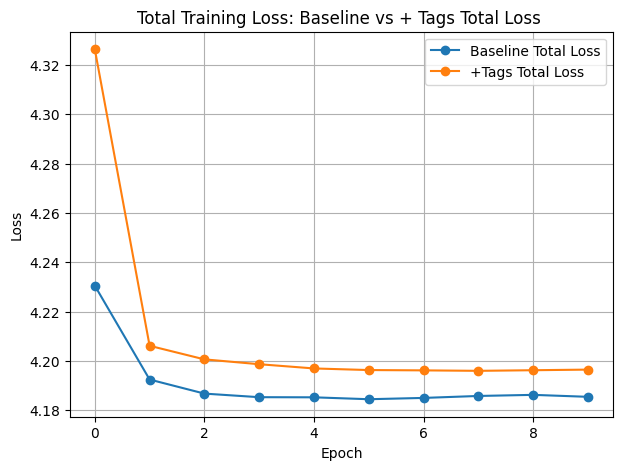

In [ ]:
# @title Baseline vs +Tags Total Loss

plt.figure(figsize=(7,5))
plt.plot(baseline_losses, label="Baseline Total Loss", marker="o")
plt.plot(tag_losses, label="+Tags Total Loss", marker="o")

plt.title("Total Training Loss: Baseline vs + Tags Total Loss ")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


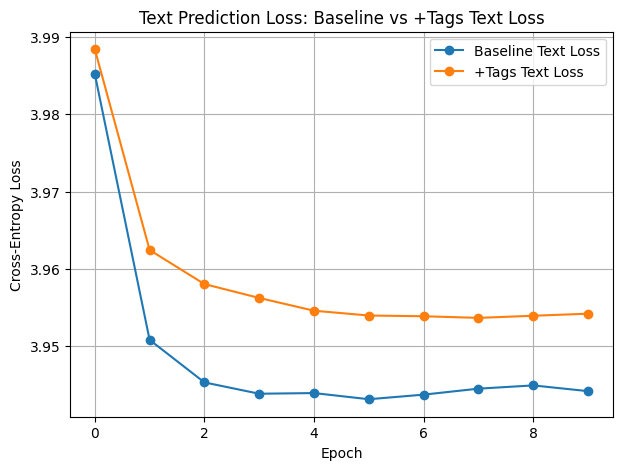

In [ ]:
# @title Baseline vs +Tags Text Loss


if "baseline_txt_losses" in globals() and "tags_txt_losses" in globals():
    plt.figure(figsize=(7,5))
    plt.plot(baseline_txt_losses, label="Baseline Text Loss", marker="o")
    plt.plot(tags_txt_losses, label="+Tags Text Loss", marker="o")

    plt.title("Text Prediction Loss: Baseline vs +Tags Text Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Cross-Entropy Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Text loss tracking not enabled — skipping text loss plot.")


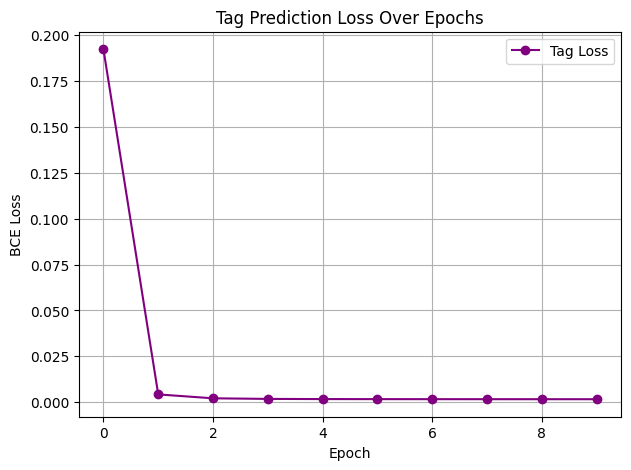

In [ ]:
# @title Tag Prediction Loss (+Tags Model Only)

if "tags_tag_losses" in globals():
    plt.figure(figsize=(7,5))
    plt.plot(tags_tag_losses, label="Tag Loss", marker="o", color="purple")

    plt.title("Tag Prediction Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("BCE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Tag loss tracking not enabled — skipping tag loss plot.")


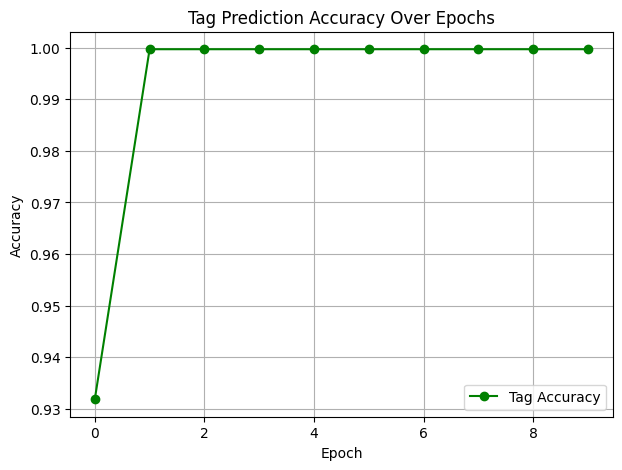

In [ ]:
# @title Tag Prediction Accuracy (+Tags Model Only)

if "tags_tag_accs" in globals():
    plt.figure(figsize=(7,5))
    plt.plot(tags_tag_accs, label="Tag Accuracy", marker="o", color="green")

    plt.title("Tag Prediction Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Tag accuracy not implemented — skipping accuracy plot.")


# **Appendix**

This code computes the average images in case you want to use them. Notice that the average should be all zeros!